# Gaussian process regression: Implementation using GPyTorch   
    
GPyTorch is a Gaussian process library implemented using PyTorch. GPyTorch is designed for creating scalable, flexible, and modular Gaussian process models with ease (https://github.com/cornellius-gp/gpytorch). GPyTorch provides significant GPU acceleration (through MVM based inference) and state-of-the-art implementations of the latest algorithmic advances for scalability and flexibility.   
   
We used GpyTorch to easily build models of GP regression and especially the exact GP regression (see gpyt_regressor.py), the PP method/Nyström approximate model and the Titsias model (see gpyt_sparse.py). The main objective of this notebook is to show some basic uses of GPyTorch and the models we implemented with simple datasets.

**Requirements** The `torch` and `gpytorch` packages *must* be installed.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import copy
import torch
from gpytorch import priors ,likelihoods, mlls
from models.gpyt_sparse import TitsiasSparseGP, NystromSparseGP
from models.gpyt_regressor import MyGPModel

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 0
np.random.rand(SEED)
torch.manual_seed(SEED)

## 1. Simple dataset

In [3]:
df_train = pd.read_csv("simple_example/Simple_train.csv")
df_test = pd.read_csv("simple_example/Simple_test.csv")

X_train, y_train = torch.from_numpy(df_train['X'].values).float(), torch.from_numpy(df_train['Y'].values).float()
X_test , y_test = torch.from_numpy(df_test['X'].values).float()  ,df_test['X'].values

Text(0.5, 1.0, 'Data')

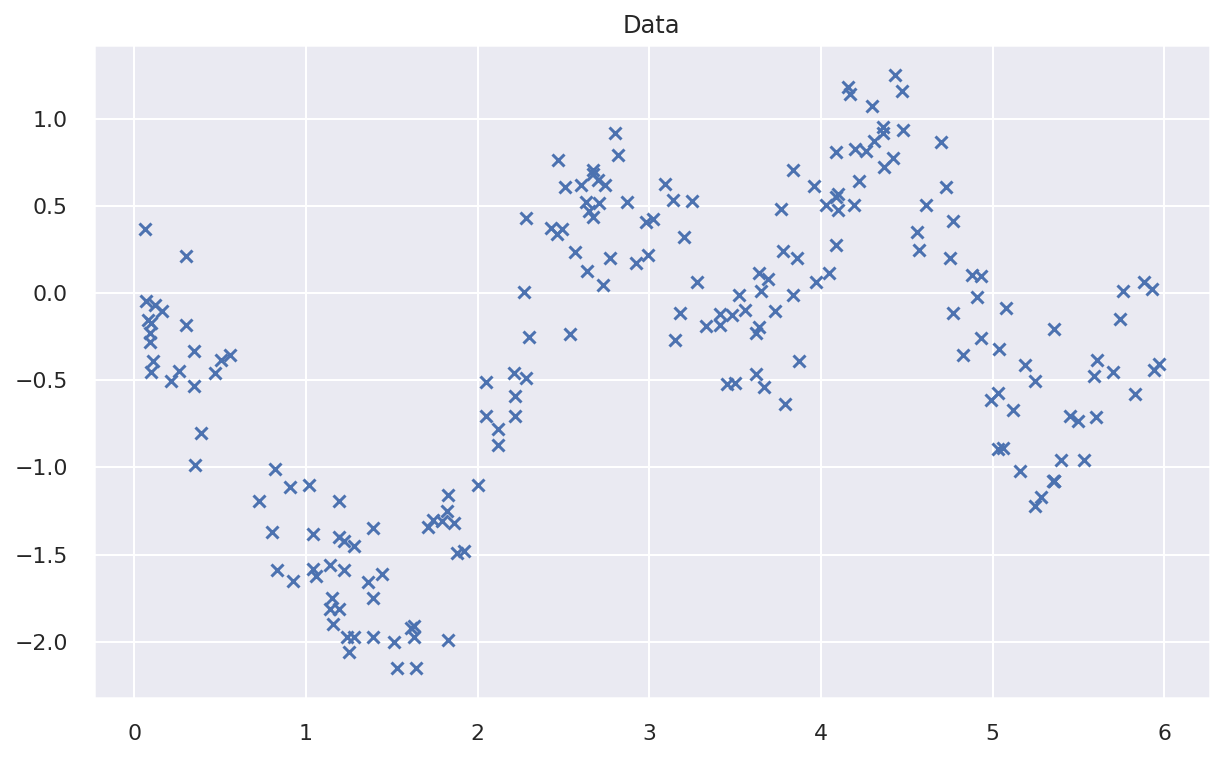

In [4]:
plt.figure(figsize=(10 , 6))
plt.scatter(df_train['X'] , df_train['Y'] , marker = 'x')
plt.title("Data")

### 1.A Exact Gaussian Process Regression

In [5]:
# Define the model
regression_loss = likelihoods.GaussianLikelihood()
model = MyGPModel(X_train, y_train, regression_loss)
model.train()
regression_loss.train()

# Define the marginal log-likelihood for the hyperparameters
marg_ll = mlls.ExactMarginalLogLikelihood(regression_loss, model)

In [6]:
# Define the optimizer (here we chose Adam optimizer) and the number of epochs
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

#Run the optimizer for 100 epochs in order to optimize the hyperparameters using loss = - marginal log-likelihood
eprange = tqdm.notebook.tqdm_notebook(range(epochs))
losses_record = []
for i in eprange:
    output = model(X_train)
    loss = -marg_ll(output, y_train)
    loss.backward()

    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0.5, 1.0, '- marginal log-likelihood for exact GP')

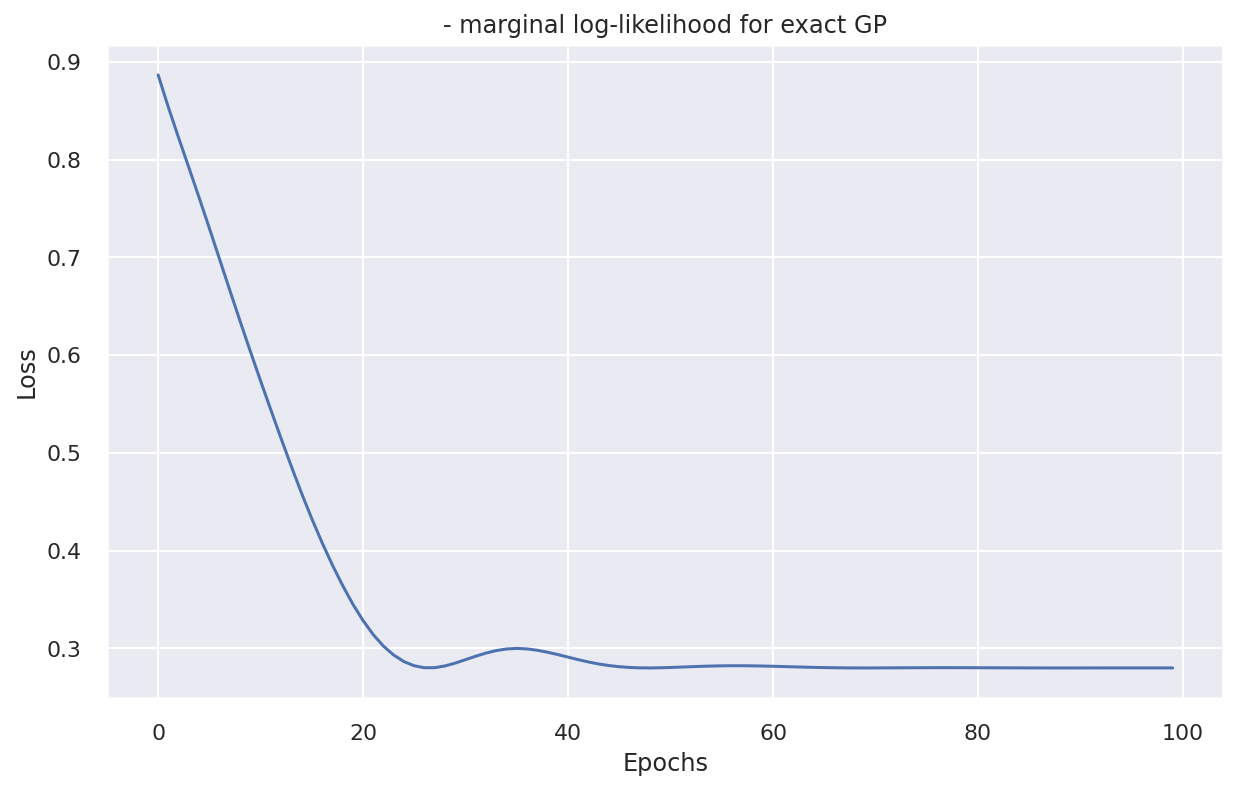

In [7]:
# Plot the loss with respect to the number of epochs
plt.figure(figsize = (10 , 6))
plt.plot(losses_record)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("- marginal log-likelihood for exact GP")

In [8]:
def make_prediction(model, x_pred):
    """Return predictive distribution at points `x_pred`."""
    return regression_loss(model(x_pred))

model.eval()
regression_loss.eval()
y_pred_test = make_prediction(model, X_test)

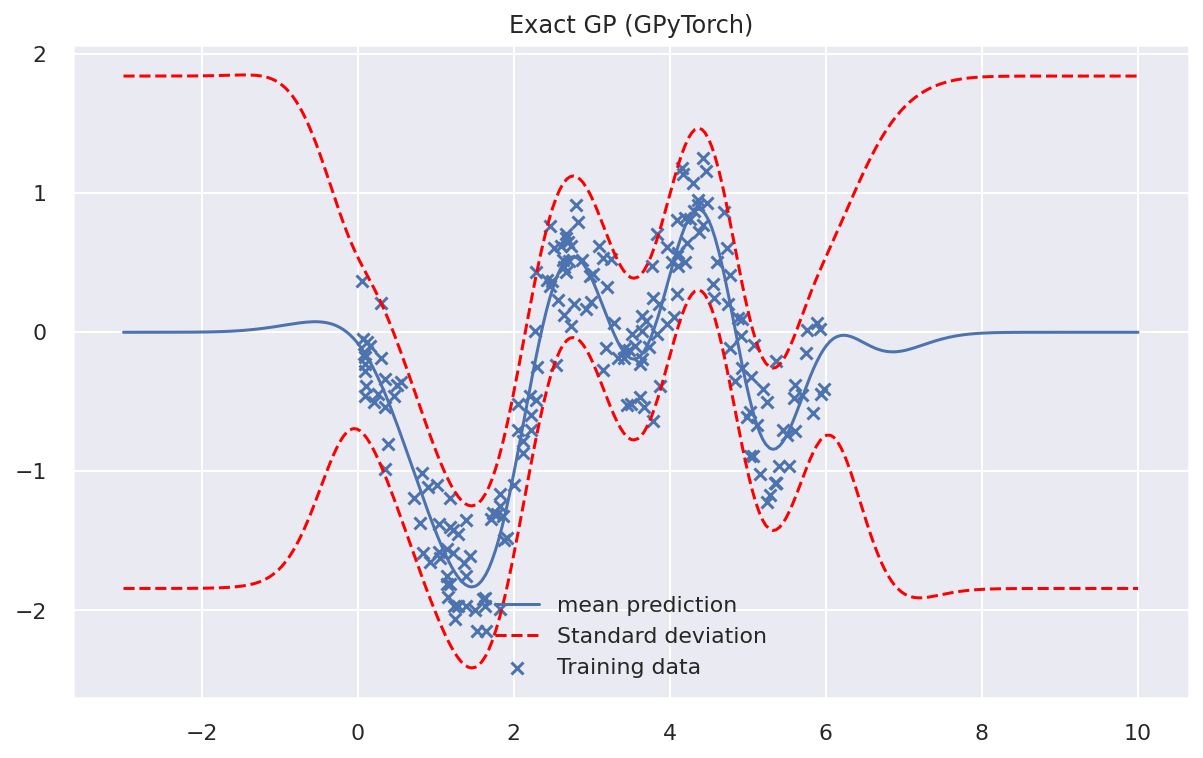

In [9]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
plt.title("Exact GP (GPyTorch)")
plt.legend()

Notice the amplitude of the posterior variance $\mathbb{V}(f(x^*))$ for values of $x^* \in\mathbb R$ far from the data.

### 1.B Nystrom approximate Gaussian Process regression (PP) vs Titsias variational regression

**Important Note**: Contrary to what is described in section 3.1 of Titsias 2009, Gpytorch does not use a greedy algorithm to select the induced points. Instead, it directly optimizes the variational lower bound. Thus we need to specify initial induced points (inducing_points_priors).

#### 1.B.1) Nyström sparse GP

In [10]:
# Define the model (for PP regression we need to specify initial inducing points)
regression_loss = likelihoods.GaussianLikelihood()

inducing_idx = np.random.choice(np.arange(X_train.shape[0]), 10, False)
inducing_points = X_train[inducing_idx]
inducing_points_prior = copy.deepcopy(inducing_points)

model = NystromSparseGP(X_train, y_train, inducing_points, regression_loss)
model.train()
regression_loss.train()

# Define the marginal log-likelihood for the hyperparameters
hyp_loss = mlls.ExactMarginalLogLikelihood(regression_loss, model)

In [11]:
# Define the optimizer (here we chose Adam optimizer) and the number of epochs
epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

#Run the optimizer for 100 epochs in order to optimize the hyperparameters using loss = - marginal log-likelihood
eprange = tqdm.notebook.tqdm_notebook(range(epochs))
losses_record = []
for i in eprange:
    output = model(X_train)
    loss = -hyp_loss(output, y_train)
    loss.backward()
    
    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0.5, 1.0, 'Marginal log-likelihood for Nyström GP')

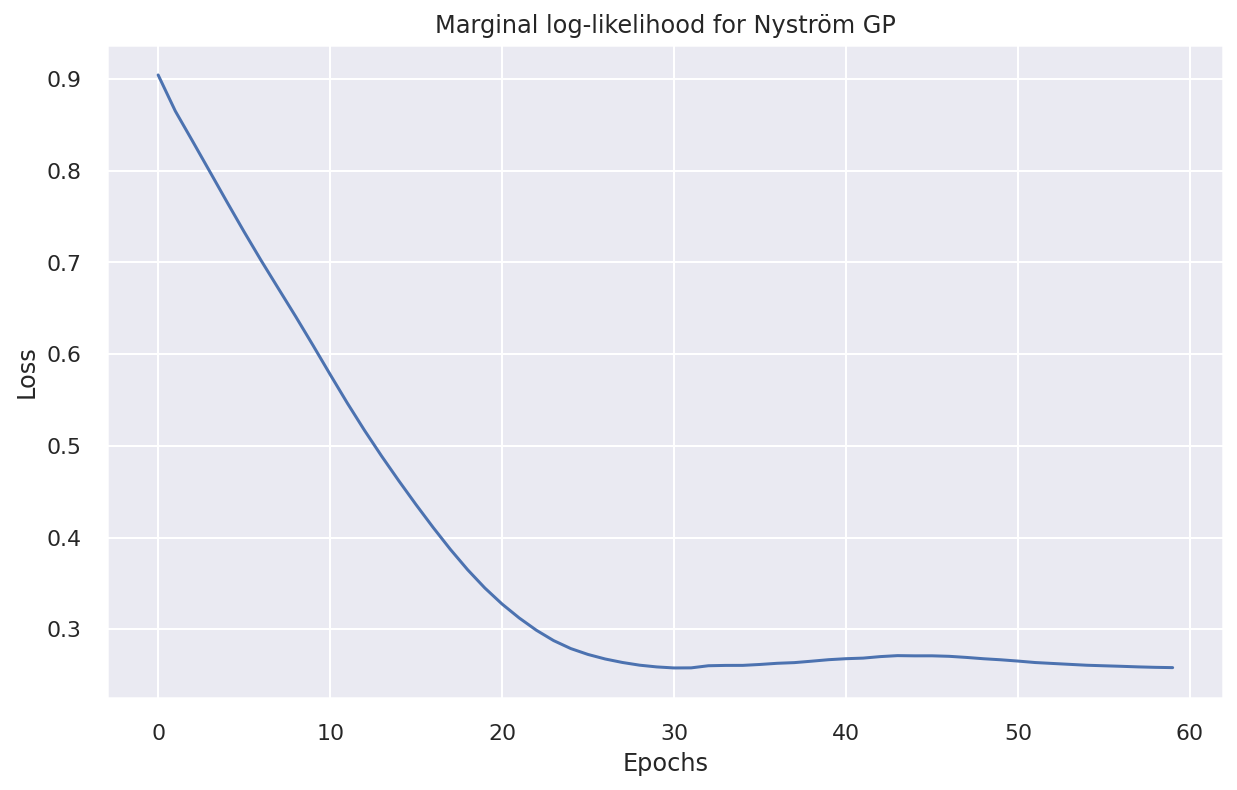

In [12]:
# Plot the loss with respect to the number of epochs
plt.figure(figsize = (10 , 6))
plt.plot(losses_record)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Marginal log-likelihood for Nyström GP")

In [13]:
model.eval()
regression_loss.eval()
y_pred_test = make_prediction(model, X_test)

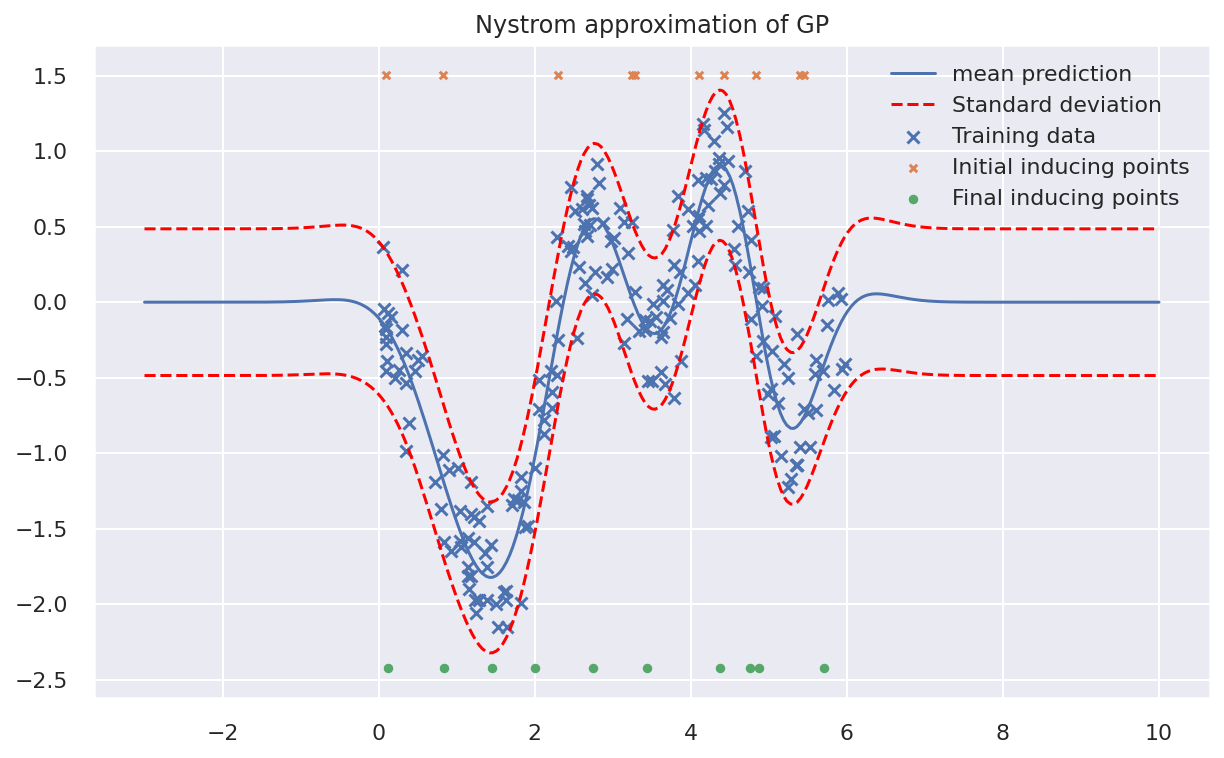

In [14]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
max_upper_std = torch.max(upper) + 0.1
plt.scatter(inducing_points_prior, max_upper_std*torch.ones_like(inducing_points_prior),
            s=14, marker="x", label="Initial inducing points")
plt.scatter(inducing_points, min_lower_std*torch.ones_like(inducing_points),
            s=14, marker="o", label="Final inducing points")
plt.title("Nystrom approximation of GP")
plt.legend()

We see that the Nyström sparse GP under-estimates the posterior variance in data-sparse areas.

#### 1.B.2) Titsias sparse GP

In [15]:
# Define the model (for PP regression we need to specify initial inducing points)
regression_loss = likelihoods.GaussianLikelihood()

inducing_idx = np.random.choice(np.arange(X_train.shape[0]), 10, False)
inducing_points = X_train[inducing_idx]
inducing_points_prior = copy.deepcopy(inducing_points)

model = TitsiasSparseGP(X_train, y_train, inducing_points, regression_loss)
model.train()
regression_loss.train()

# Define the marginal log-likelihood for the hyperparameters
hyp_loss = mlls.ExactMarginalLogLikelihood(regression_loss, model)

In [16]:
# Define the optimizer (here we chose Adam optimizer) and the number of epochs
epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

#Run the optimizer for 100 epochs in order to optimize the hyperparameters using loss = - marginal log-likelihood
eprange = tqdm.notebook.tqdm_notebook(range(epochs))
losses_record = []
for i in eprange:
    output = model(X_train)
    loss = -hyp_loss(output, y_train)
    loss.backward()
    
    eprange.set_postfix({"mll": loss.data.item()})
    losses_record.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0.5, 1.0, 'Marginal log-likelihood for the Titsias sparse GP')

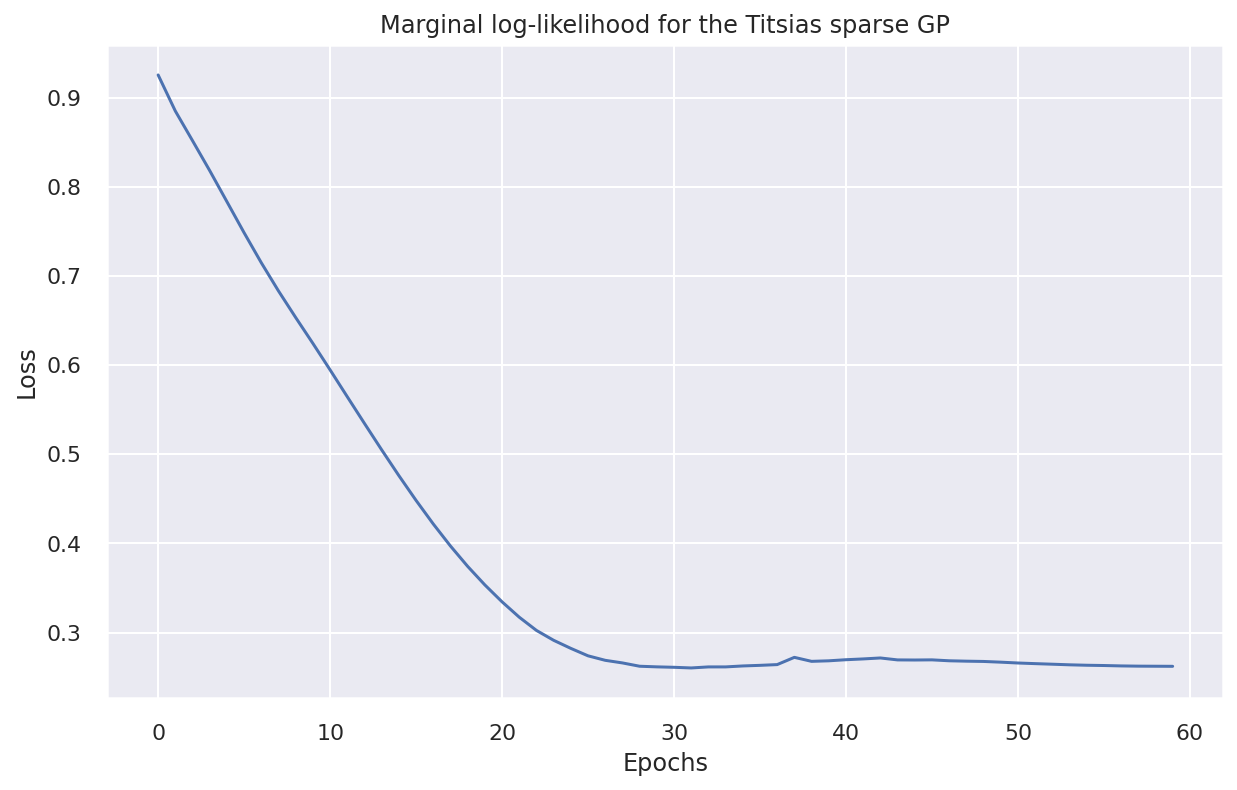

In [17]:
# Plot the loss with respect to the number of epochs
plt.figure(figsize = (10 , 6))
plt.plot(losses_record)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Marginal log-likelihood for the Titsias sparse GP")

In [18]:
model.eval()
regression_loss.eval()
y_pred_test = make_prediction(model, X_test)

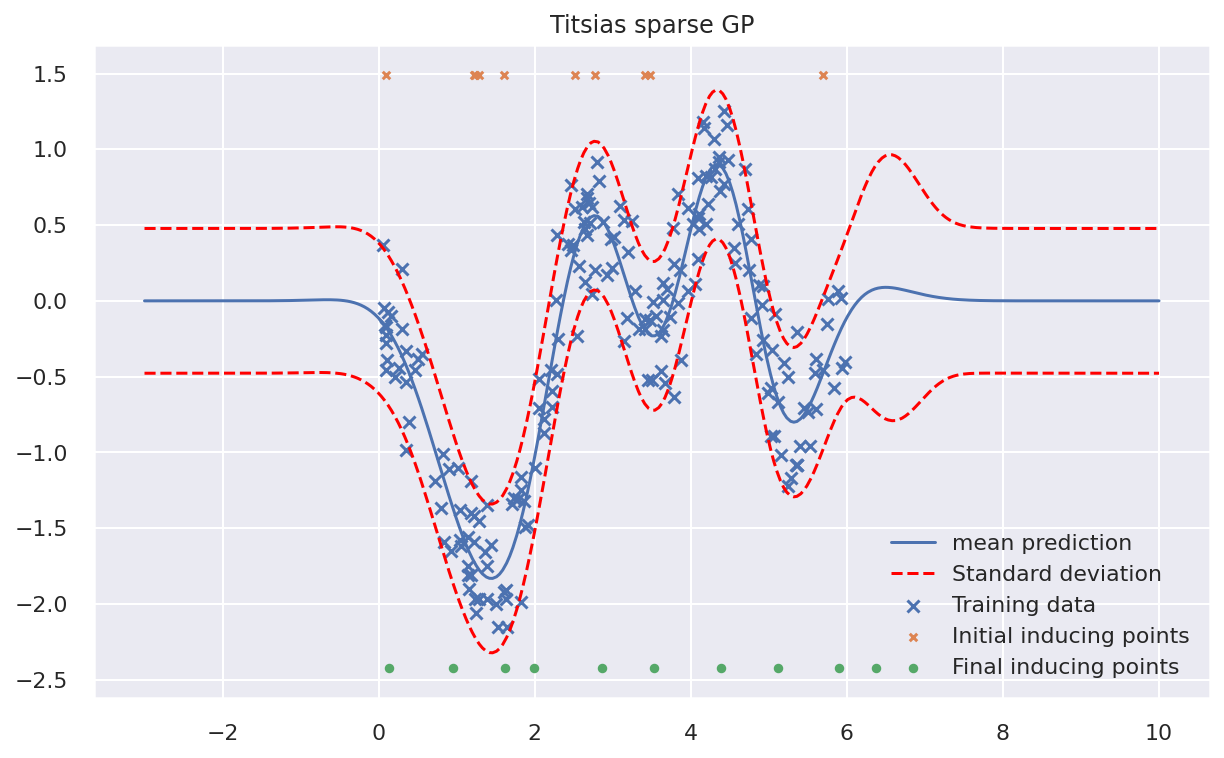

In [19]:
plt.figure(figsize=(10 , 6))
plt.scatter(X_train.data, y_train.data, marker = 'x' ,label = 'Training data')
plt.plot(X_test.data, y_pred_test.mean.data, 'b' , label = 'mean prediction')
lower, upper = y_pred_test.confidence_region()
lower.detach_()
upper.detach_()

plt.plot(X_test.data, lower, '--' ,  color='red' , label = 'Standard deviation')
plt.plot(X_test.data, upper, '--' , color='red')
min_lower_std = torch.min(lower) - 0.1
max_upper_std = torch.max(upper) + 0.1
plt.scatter(inducing_points_prior, max_upper_std*torch.ones_like(inducing_points_prior),
            s=14, marker="x", label="Initial inducing points")
plt.scatter(inducing_points, min_lower_std*torch.ones_like(inducing_points),
            s=14, marker="o", label="Final inducing points")
plt.title("Titsias sparse GP")
plt.legend()

The same posterior variance under-estimation effect can be observed for the Titsias sparse GP.

## 2. Boston dataset

No. of covariates: 13
Train size: 404
Valid size: 102


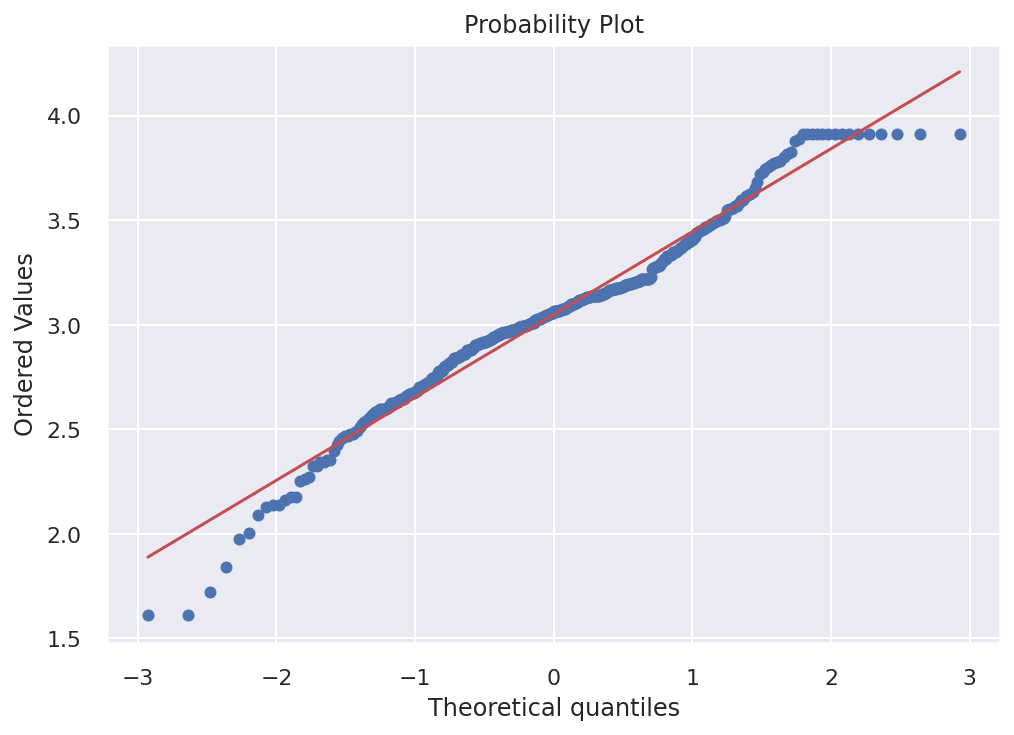

In [291]:
from torch.nn import functional as F
import scipy.stats

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

X_all, y_all = load_boston(return_X_y=True)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=.2)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

print("No. of covariates:", X_train.shape[1])
print("Train size:", X_train.shape[0])
print("Valid size:", X_val.shape[0])

_ = scipy.stats.probplot(y_train.log(), plot=sns.mpl.pyplot)

In [292]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [480]:
linmodel = LinearRegression()\
                .fit(X_train.detach().numpy(),
                     y_train.detach().numpy())

lin_score_ = mean_squared_error(linmodel.predict(X_val.data), y_val.data, squared=False)
print("Linear model:", lin_score_)

rfmodel = RandomForestRegressor()\
                .fit(X_train.detach().numpy(),
                     y_train.detach().numpy())

rf_score_ = mean_squared_error(rfmodel.predict(X_val.data), y_val.data, squared=False)
print("Random forest:", rf_score_)

Linear model: 4.298873
Random forest: 3.3683573976773116


In [571]:
# Model likelihood
# used for regression
likelihood = likelihoods.GaussianLikelihood()

num_induce_ = 150
inducing_idx = np.random.choice(
    np.arange(X_train.shape[0]), num_induce_, False)
inducing_points = X_train[inducing_idx]  # modified in-place
print("Inducing points:", inducing_points.shape[0])
inducing_points_prior = copy.deepcopy(inducing_points)  # not modified

# model = MyGPModel(X_train, y_train, likelihood)
model = TitsiasSparseGP(X_train, y_train, inducing_points, likelihood)

likelihood.train()
model.train();

matern_nu = 2.5

Inducing points: 150


In [572]:
# OPTIMIZE THE HYPERPARAMETERS

# Step 2: define marginal log likelihood
# we can use the exact marginal log likelihood because the dataset is small and
# regression is simple
marg_ll = mlls.ExactMarginalLogLikelihood(likelihood, model)

epochs = 450
optimizer = torch.optim.Adam(model.parameters(), lr=1.3)

import tqdm
eprange = tqdm.notebook.tnrange(epochs)

marginal_losses = []
val_reg_losses = []

for i in eprange:
    model.train()
    likelihood.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = -marg_ll(output, y_train)
    loss.backward()
    
    marginal_losses.append(loss.item())

    optimizer.step()
    
    with torch.no_grad():
        model.eval()
        likelihood.eval()
        y_pred_dist = likelihood(model(X_val))
        y_pred_mean = y_pred_dist.mean
        val_loss = torch.sqrt(F.mse_loss(y_pred_mean, y_val,
                                         reduction='mean'))
        val_reg_losses.append(val_loss.item())
    eprange.set_postfix({"MLL": loss.data.item(), "val RMSE": val_loss.item()})
        

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [573]:
# experiment_data = {}
experiment_data[inducing_idx.shape[0]] = (marginal_losses.copy(), val_reg_losses.copy())
# experiment_data["exact"] = (marginal_losses.copy(), val_reg_losses.copy())
experiment_data.keys()

dict_keys([10, 40, 100, 150])

We also try a linear regression model:

Text(0.5, 0.98, 'RBF kernel')

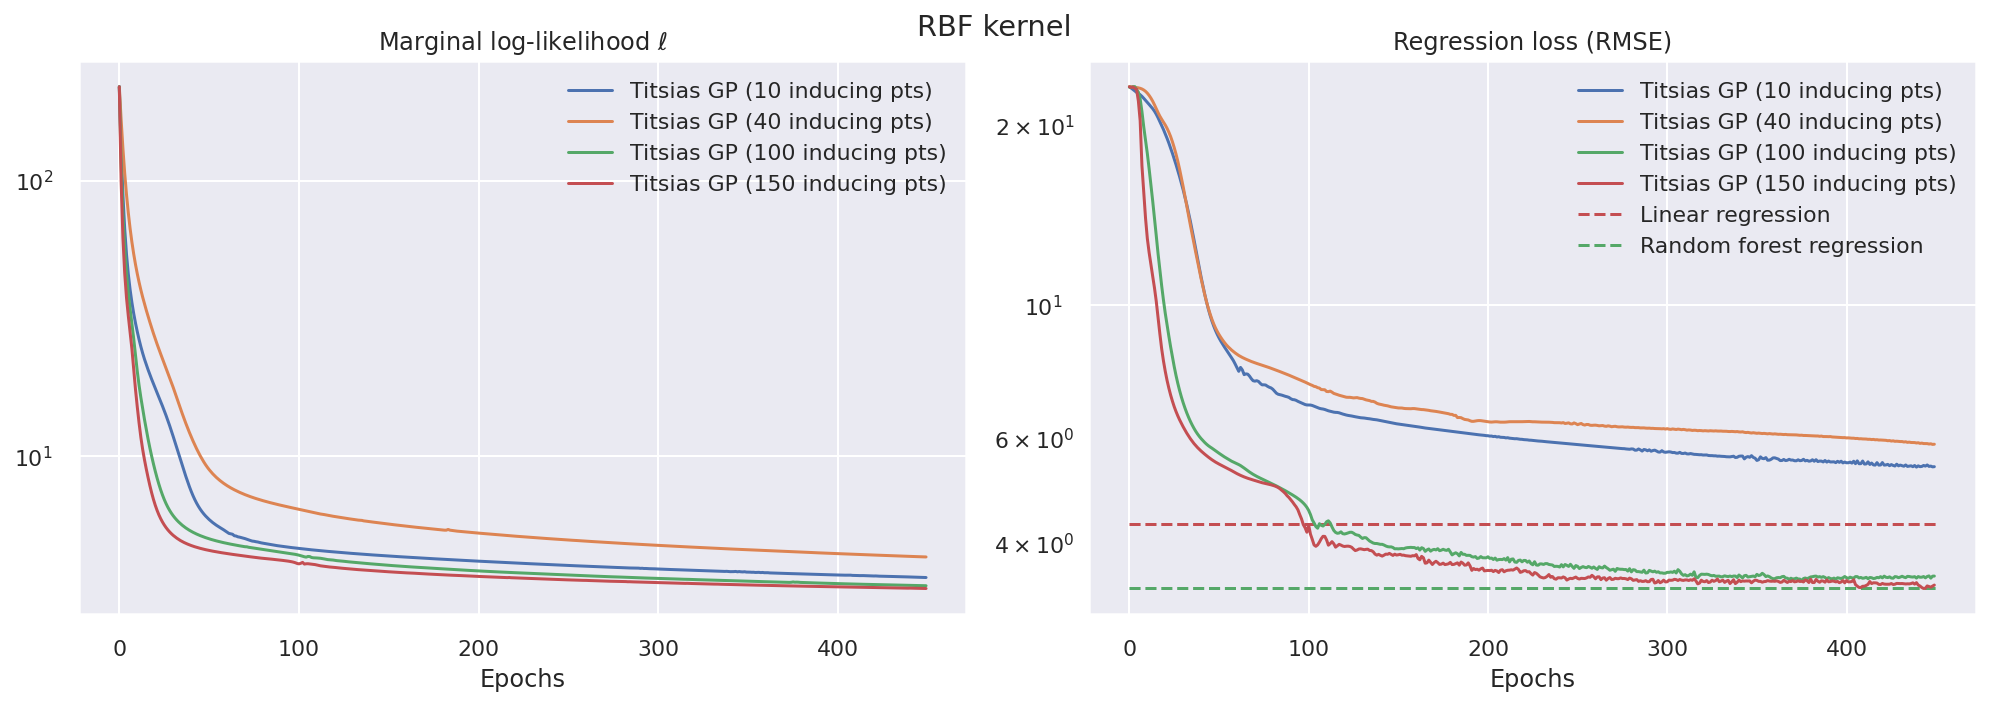

In [574]:
fig = plt.figure(figsize=(14, 5))
ax1 = plt.subplot(121)
ax1.set_title("Marginal log-likelihood $\\ell$")
ax1.set_xlabel("Epochs")
ax1.set_yscale("log")

ax2 = plt.subplot(122)
for num_, (marg_, vr_) in experiment_data.items():
    if num_ == "exact":
        lab_ = "Exact GP"
    else:
        lab_ = "Titsias GP (%d inducing pts)" % num_
    ax1.plot(np.asarray(marg_), label=lab_)
    ax2.plot(vr_, label=lab_)
lims_ = plt.xlim()
ax2.hlines(lin_score_, 0, epochs, color='r', ls='--', label="Linear regression")
ax2.hlines(rf_score_, 0, epochs, color='g', ls='--', label="Random forest regression")
ax2.set_title("Regression loss (RMSE)")
ax1.legend()
ax2.legend()
ax2.set_yscale('log')
plt.xlabel("Epochs")
fig.tight_layout()
fig.suptitle("RBF kernel")
# fig.suptitle("Matérn kernel $\\nu=%.2g$" % matern_nu)

In [575]:
fig.savefig("simple_example/Titsias_Boston_inducingPtNumInfluence.png".format(matern_nu))
fig.savefig("simple_example/Titsias_Boston_inducingPtNumInfluence.pdf".format(matern_nu))